# How smoking impacts the nose and throat microbiomes

## Data inspection

In [1]:
import biom
table = biom.load_table('data/otu_table.biom')
table

4572 x 290 <class 'biom.table.Table'> with 51574 nonzero entries (3% dense)

In [2]:
print(table.ids()[0])

524.ESC.1.65.NPR


In [3]:
print(table.ids(axis = 'observation'))

['547831' '206494' '4333043' ... '279470' '279473' '4436135']


## Import data into calour

In [4]:
import calour as ca
ca.set_log_level(11)
%matplotlib inline

import numpy as np
np.random.seed(2018)

ca.__version__

'2019.5.1'

In [5]:
cfs=ca.read_amplicon('data/otu_table.biom',
                     'data/metadata.txt',
                     normalize=10000,min_reads=1000)

2024-09-08 14:01:40 INFO loaded 290 samples, 4572 features
2024-09-08 14:01:40 WARNING These have metadata but do not have data - dropped (1): {'524.ESC.1.54.OPR'}
2024-09-08 14:01:40 WARNING Do you forget to normalize your data? It is required before running this function
2024-09-08 14:01:40 INFO After filtering, 272 remain.


/Users/phuonganh/CAB420/CAB420_VENV/lib/python3.9/site-packages/calour/util.py:246: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not isinstance(exp.feature_metadata['taxonomy'][0], list):


In [6]:
print(cfs)

AmpliconExperiment with 272 samples, 4572 features


The file contains 290 samples and 4,572 features, which matches expectations based on initial data inspection. Setting a minimum threshold of 1,000 reads reduces the dataset to 272 samples.

## Function to report OTUs

In [7]:
import pandas as pd

# Read the taxonomy file
taxonomy_df = pd.read_csv('data/97_otu_taxonomy.txt', sep='\t', header=None)
taxonomy_df.columns = ['OTU_ID', 'Taxonomy']

# Split the taxonomy string by ';' into taxonomy levels
taxonomy_split = taxonomy_df['Taxonomy'].str.split(';', expand=True)

# Assign column names
taxonomy_split.columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

# Remove prefixes
prefixes = {
    'k__': 'Kingdom',
    'p__': 'Phylum',
    'c__': 'Class',
    'o__': 'Order',
    'f__': 'Family',
    'g__': 'Genus',
    's__': 'Species'
}

for prefix, column in prefixes.items():
    taxonomy_split[column] = taxonomy_split[column].str.replace(prefix, '', regex=False)
    
# Concatenate the OTU_ID column with the taxonomy columns
final_taxonomy_df = pd.concat([taxonomy_df['OTU_ID'], taxonomy_split], axis=1)
print(final_taxonomy_df.head())

   OTU_ID   Kingdom           Phylum                 Class              Order  \
0  367523  Bacteria    Bacteroidetes        Flavobacteriia   Flavobacteriales   
1  187144  Bacteria       Firmicutes            Clostridia      Clostridiales   
2  836974  Bacteria    Cyanobacteria           Chloroplast           Cercozoa   
3  310669  Bacteria       Firmicutes            Clostridia      Clostridiales   
4  823916  Bacteria   Proteobacteria   Gammaproteobacteria    Pseudomonadales   

               Family            Genus Species  
0   Flavobacteriaceae   Flavobacterium          
1                                               
2                                               
3                                               
4       Moraxellaceae    Enhydrobacter          


In [8]:
# Function to report the most informative level of the OTU
def get_most_informative_taxonomy(row):
    if pd.notna(row['Species']) and row['Species'].strip():
        return f"{row['Genus']} {row['Species']}"
    elif pd.notna(row['Genus']) and row['Genus'].strip():
        return row['Genus']
    elif pd.notna(row['Family']) and row['Family'].strip():
        return row['Family']
    elif pd.notna(row['Order']) and row['Order'].strip():
        return row['Order']
    elif pd.notna(row['Class']) and row['Class'].strip():
        return row['Class']
    elif pd.notna(row['Phylum']) and row['Phylum'].strip():
        return row['Phylum']
    elif pd.notna(row['Kingdom']) and row['Kingdom'].strip():
        return row['Kingdom']
    else:
        return 'Unclassified'

## Data cleaning

In [9]:
# Remove non-interesting bacteria with less than 10 reads over all the samples
cfs = cfs.filter_sum_abundance(10)

2024-09-08 14:01:41 INFO After filtering, 2171 remain.


In [10]:
# Cluster the bacteria
cfs = cfs.cluster_features()

2024-09-08 14:01:41 INFO After filtering, 2171 remain.


## Parameters choice

- Control method (discrete FDR): Given that this analysis works with OTUs (Operational Taxonomic Units), which typically involve count data and discrete p-values rather than continuous ones. The dsfdr method is specifically designed to handle this type of data, making it more appropriate than other methods.
- Alpha (0.05): This is the most commonly used threshold in statistical analyses, including those in microbiome research. It provides a reasonable balance between stringency and power, making it a widely accepted choice in scientific research. It indicates that among the discoveries (rejected null hypotheses), it is expected that 5% of them might be false positives.

## Task 1: Identify which bacteria have a differential abundance between the nose and throat (irrespective of the smoking status)

2024-09-08 14:01:41 WARNING Database interface dbbact_calour.dbbact not installed.
Skipping.
You can install the database using:
pip install git+git://github.com/amnona/dbbact-calour
For details see: www.dbbact.org


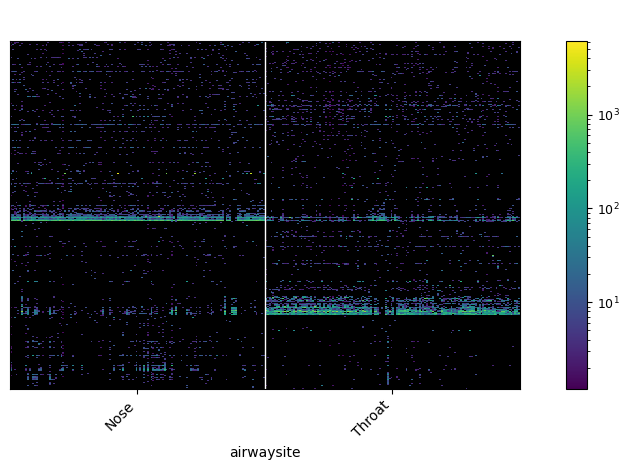

In [11]:
# Sort the samples according to the airwaysite
cfs_1 = cfs.sort_samples('airwaysite')
cfs_1.plot(sample_field = 'airwaysite')

2024-09-08 14:01:42 INFO 272 samples with both values
2024-09-08 14:01:42 INFO After filtering, 2171 remain.
2024-09-08 14:01:42 INFO 136 samples with value 1 (['Nose'])
2024-09-08 14:01:43 INFO number of higher in Nose: 491. number of higher in Throat : 529. total 1020
2024-09-08 14:01:43 WARNING Database interface dbbact_calour.dbbact not installed.
Skipping.
You can install the database using:
pip install git+git://github.com/amnona/dbbact-calour
For details see: www.dbbact.org


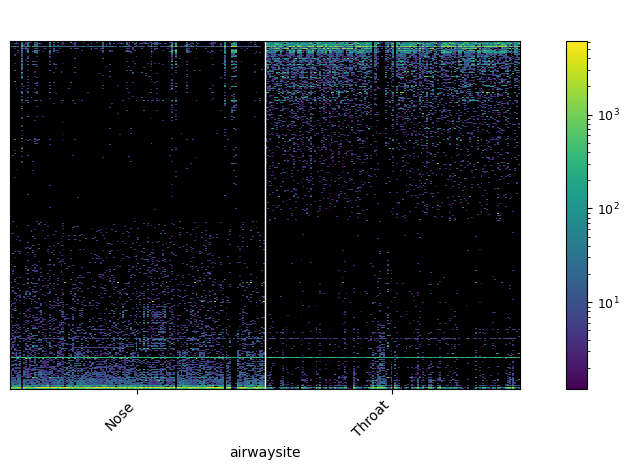

In [12]:
# Diffential abundance
dd_1=cfs_1.diff_abundance('airwaysite','Nose','Throat', fdr_method='dsfdr', alpha = 0.05, 
                          random_seed=2018)
dd_1.plot(sample_field = 'airwaysite')

Overall, there are 1020 samples that have a statistically significant differrence in abundance  between the two groups. In these samples, there are 491 samples that have a higher abundance in the Nose group and 529 samples that have higher abundance in the Throat group.

In [13]:
# Report OTUs
otu_ids = set(dd_1.feature_metadata.index)

# Loop through each OTU_ID in the set
final_taxonomy_df['OTU_ID'] = final_taxonomy_df['OTU_ID'].astype(str)
otu_ids = {str(otu_id) for otu_id in otu_ids}

for otu_id in otu_ids:
    if otu_id in final_taxonomy_df['OTU_ID'].values:
        
        # Get the corresponding taxonomy row and apply pre-defined function
        taxonomy_row = final_taxonomy_df.loc[final_taxonomy_df['OTU_ID'] == otu_id]
        informative_taxonomy = get_most_informative_taxonomy(taxonomy_row.iloc[0])
        
        # Display the OTU_ID and its most informative taxonomy
        print(f"OTU_ID: {otu_id} - {informative_taxonomy}")
    else:
        print(f"OTU_ID: {otu_id} not found in the taxonomy data.")

OTU_ID: 610111 -  Prevotella
OTU_ID: 299439 -  Prevotella
OTU_ID: 4418243 -  Prevotella
OTU_ID: 4451646 -  Capnocytophaga
OTU_ID: 4303114 -  Haemophilus  parainfluenzae
OTU_ID: 218322 -  ZB2
OTU_ID: 103876 -  CF231
OTU_ID: 236650 -  Anaerococcus
OTU_ID: 4470870 -  [Barnesiellaceae]
OTU_ID: 192127 -  Lachnospiraceae
OTU_ID: 541884 -  Chitinimonas  taiwanensis
OTU_ID: 4454385 -  Prevotella
OTU_ID: 4373301 -  Bacteroidales
OTU_ID: 564674 -  Paenibacillus
OTU_ID: 1817088 -  Propionibacteriaceae
OTU_ID: 965048 -  Neisseriaceae
OTU_ID: 960184 -  Streptococcus
OTU_ID: 802048 -  Rheinheimera
OTU_ID: 3866487 -  Oribacterium
OTU_ID: 4297119 -  Leptotrichia
OTU_ID: 352918 -  Ruminococcaceae
OTU_ID: 531046 -  Prevotella
OTU_ID: 261296 -  Paenibacillus
OTU_ID: 178888 -  Ruminococcaceae
OTU_ID: 4415965 -  Clostridiales
OTU_ID: 4468073 -  Capnocytophaga
OTU_ID: 1002634 -  Anaerococcus
OTU_ID: 289974 -  Lactococcus
OTU_ID: 4456252 -  Megasphaera
OTU_ID: 917819 -  Parvimonas
OTU_ID: 211539 -  Streptomy

## Task 2: Identify which bacteria have a differential abundance between smokers and non-smokers (irrespective of the sampling site).

2024-09-08 14:01:52 WARNING Database interface dbbact_calour.dbbact not installed.
Skipping.
You can install the database using:
pip install git+git://github.com/amnona/dbbact-calour
For details see: www.dbbact.org


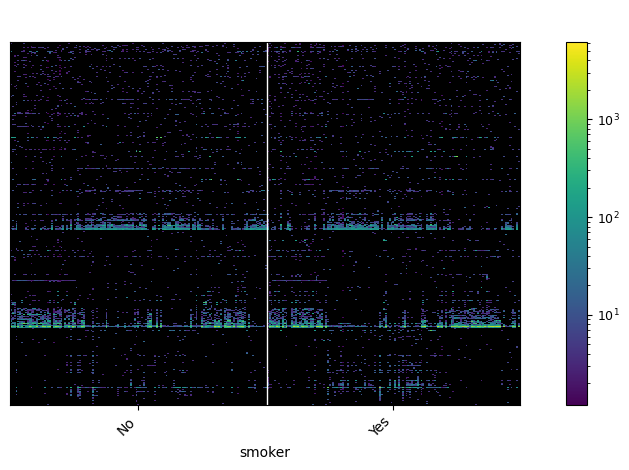

In [14]:
# Sort the samples according to the smoking status
cfs_2 = cfs.sort_samples('smoker')
cfs_2.plot(sample_field = 'smoker')

2024-09-08 14:01:52 INFO 272 samples with both values
2024-09-08 14:01:52 INFO After filtering, 2171 remain.
2024-09-08 14:01:52 INFO 135 samples with value 1 (['Yes'])
2024-09-08 14:01:54 INFO number of higher in Yes: 57. number of higher in No : 18. total 75
2024-09-08 14:01:54 WARNING Database interface dbbact_calour.dbbact not installed.
Skipping.
You can install the database using:
pip install git+git://github.com/amnona/dbbact-calour
For details see: www.dbbact.org


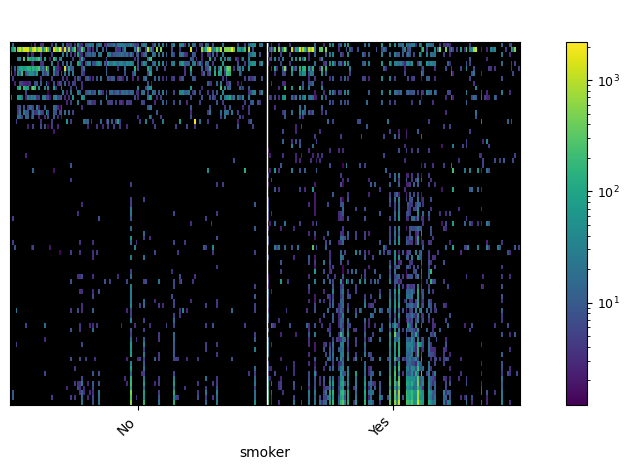

In [15]:
# Diffential abundance
dd_2=cfs_2.diff_abundance('smoker','Yes','No', fdr_method='dsfdr', alpha = 0.05, random_seed=2018)
dd_2.plot(sample_field = 'smoker')

Overall, there are 75 samples that have a statistically significant differrence in abundance between the two groups. In these samples, there 57 samples that have a higher abundance in the Smokers group and 18 samples that have higher abundance in the Non-smokers group.

In [16]:
# Report OTUs
otu_ids = set(dd_2.feature_metadata.index)

# Loop through each OTU_ID in the set
final_taxonomy_df['OTU_ID'] = final_taxonomy_df['OTU_ID'].astype(str)
otu_ids = {str(otu_id) for otu_id in otu_ids}

for otu_id in otu_ids:
    if otu_id in final_taxonomy_df['OTU_ID'].values:
        
        # Get the corresponding taxonomy row and apply pre-defined function 
        taxonomy_row = final_taxonomy_df.loc[final_taxonomy_df['OTU_ID'] == otu_id]
        informative_taxonomy = get_most_informative_taxonomy(taxonomy_row.iloc[0])
        
        # Display the OTU_ID and its most informative taxonomy
        print(f"OTU_ID: {otu_id} - {informative_taxonomy}")
    else:
        print(f"OTU_ID: {otu_id} not found in the taxonomy data.")

OTU_ID: 557093 -  Enterobacteriaceae
OTU_ID: 4433523 -  Capnocytophaga
OTU_ID: 753638 -  Dialister
OTU_ID: 182122 -  Lachnospiraceae
OTU_ID: 751601 -  Lactobacillus  zeae
OTU_ID: 992686 -  WAL_1855D
OTU_ID: 218785 -  Neisseria
OTU_ID: 71577 -  Flavobacterium
OTU_ID: 196572 -  Clostridiales
OTU_ID: 185190 -  Lachnospiraceae
OTU_ID: 179319 -  Dorea
OTU_ID: 191754 -  Oscillospira
OTU_ID: 181834 -  Lachnospiraceae
OTU_ID: 184882 -  Blautia
OTU_ID: 2576209 -  Pseudoramibacter_Eubacterium
OTU_ID: 4454893 -  Flavobacterium
OTU_ID: 178621 -  Coprococcus
OTU_ID: 255809 -  Alicyclobacillaceae
OTU_ID: 583522 -  Veillonellaceae
OTU_ID: 192619 -  Lachnospiraceae
OTU_ID: 4361797 -  Flavobacterium
OTU_ID: 332355 -  Zoogloea
OTU_ID: 1096610 -  Finegoldia
OTU_ID: 257492 -  Aerococcaceae
OTU_ID: 3297209 -  Rhodocyclaceae
OTU_ID: 178665 -  Lachnospiraceae
OTU_ID: 178627 -  Lachnospiraceae
OTU_ID: 347882 -  RF16
OTU_ID: 4463709 -  Coprococcus
OTU_ID: 4393532 -  Eggerthella  lenta
OTU_ID: 190633 -  Blautia

## Task 3: 
## 3.1 Identify which bacteria have a differential abundance in the nose between smokers and non-smokers.

In [17]:
# Filter for nose site
cfs_nose = cfs.filter_samples('airwaysite', 'Nose')

2024-09-08 14:01:55 WARNING Database interface dbbact_calour.dbbact not installed.
Skipping.
You can install the database using:
pip install git+git://github.com/amnona/dbbact-calour
For details see: www.dbbact.org


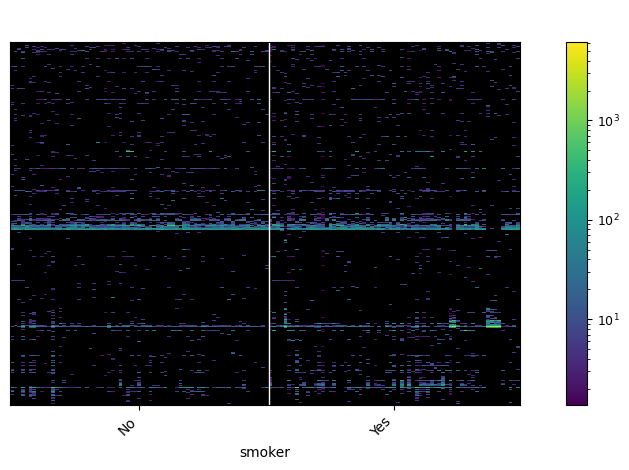

In [18]:
# Sort the samples according to the smoking status
cfs_nose = cfs_nose.sort_samples('smoker')
cfs_nose.plot(sample_field = 'smoker')

2024-09-08 14:01:55 INFO 136 samples with both values
2024-09-08 14:01:55 INFO After filtering, 1792 remain.
2024-09-08 14:01:55 INFO 67 samples with value 1 (['Yes'])
2024-09-08 14:01:56 INFO number of higher in Yes: 71. number of higher in No : 12. total 83
2024-09-08 14:01:56 WARNING Database interface dbbact_calour.dbbact not installed.
Skipping.
You can install the database using:
pip install git+git://github.com/amnona/dbbact-calour
For details see: www.dbbact.org


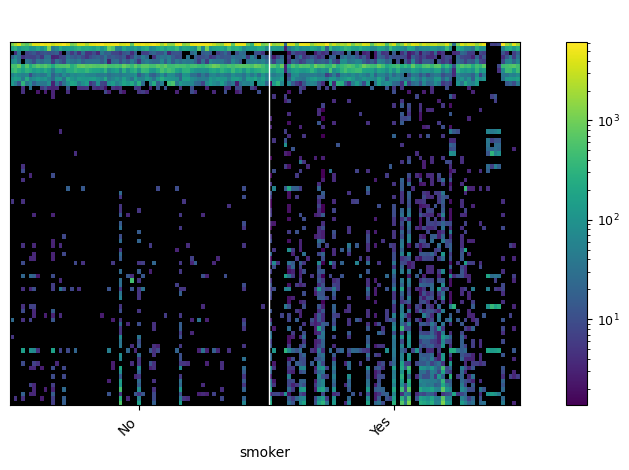

In [19]:
# Diffential abundance
dd_nose = cfs_nose.diff_abundance('smoker','Yes','No', fdr_method='dsfdr', alpha = 0.05, 
                                  random_seed=2018)
dd_nose.plot(sample_field = 'smoker')

Overall, there are 83 samples that have a statistically significant differrence in abundance between the two groups. In these samples, there are 71 samples that have a higher abundance in the Smokers group and 12 samples that have higher abundance in the Non-smokers group.

In [20]:
# Report OTUs
otu_ids = set(dd_nose.feature_metadata.index)

# Loop through each OTU_ID in the set
final_taxonomy_df['OTU_ID'] = final_taxonomy_df['OTU_ID'].astype(str)
otu_ids = {str(otu_id) for otu_id in otu_ids}

for otu_id in otu_ids:
    if otu_id in final_taxonomy_df['OTU_ID'].values:
        
        # Get the corresponding taxonomy row and apply pre-defined function
        taxonomy_row = final_taxonomy_df.loc[final_taxonomy_df['OTU_ID'] == otu_id]
        informative_taxonomy = get_most_informative_taxonomy(taxonomy_row.iloc[0])
        
        # Display the OTU_ID and its most informative taxonomy
        print(f"OTU_ID: {otu_id} - {informative_taxonomy}")
    else:
        print(f"OTU_ID: {otu_id} not found in the taxonomy data.")

OTU_ID: 753638 -  Dialister
OTU_ID: 4393019 -  Catonella
OTU_ID: 179319 -  Dorea
OTU_ID: 252679 -  Leuconostoc  fallax
OTU_ID: 539924 -  Zoogloea
OTU_ID: 4463709 -  Coprococcus
OTU_ID: 4393532 -  Eggerthella  lenta
OTU_ID: 4374639 -  Haemophilus  parainfluenzae
OTU_ID: 4467774 -  Propionibacterium  acnes
OTU_ID: 250269 -  Veillonellaceae
OTU_ID: 199422 -  Oscillospira
OTU_ID: 128382 -  Dialister
OTU_ID: 179796 -  Lachnospiraceae
OTU_ID: 178882 -  Coprococcus
OTU_ID: 197105 -  [Eubacterium]  biforme
OTU_ID: 178843 -  Clostridiales
OTU_ID: 179408 -  [Ruminococcus]
OTU_ID: 1076668 -  Aerococcaceae
OTU_ID: 851668 -  Prevotella
OTU_ID: 185190 -  Lachnospiraceae
OTU_ID: 181834 -  Lachnospiraceae
OTU_ID: 255809 -  Alicyclobacillaceae
OTU_ID: 178621 -  Coprococcus
OTU_ID: 257492 -  Aerococcaceae
OTU_ID: 332355 -  Zoogloea
OTU_ID: 1096610 -  Finegoldia
OTU_ID: 4465561 -  Prevotella  melaninogenica
OTU_ID: 288680 -  Lactococcus
OTU_ID: 46931 -  Brenneria  salicis
OTU_ID: 205118 -  RF16
OTU_ID: 1

## 3.2 Identify which bacteria have a differential abundance in the throat between smokers and non-smokers

In [21]:
# Filter for throat site
cfs_throat = cfs.filter_samples('airwaysite', 'Throat')

2024-09-08 14:01:58 WARNING Database interface dbbact_calour.dbbact not installed.
Skipping.
You can install the database using:
pip install git+git://github.com/amnona/dbbact-calour
For details see: www.dbbact.org


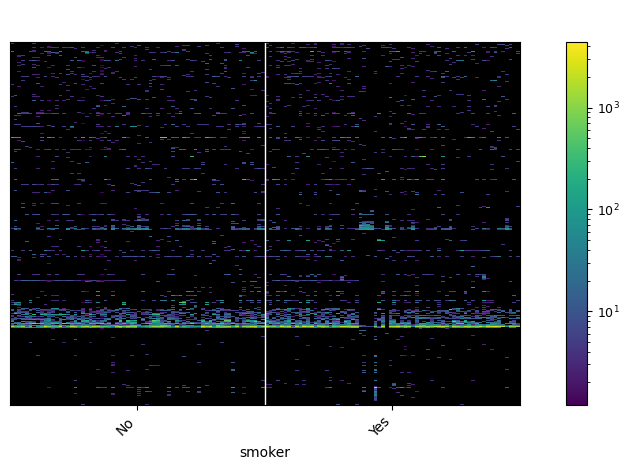

In [22]:
# Sort the samples according to the smoking status
cfs_throat = cfs_throat.sort_samples('smoker')
cfs_throat.plot(sample_field = 'smoker')

2024-09-08 14:01:58 INFO 136 samples with both values
2024-09-08 14:01:58 INFO After filtering, 1682 remain.
2024-09-08 14:01:58 INFO 68 samples with value 1 (['Yes'])
2024-09-08 14:01:59 INFO number of higher in Yes: 11. number of higher in No : 25. total 36
2024-09-08 14:01:59 WARNING Database interface dbbact_calour.dbbact not installed.
Skipping.
You can install the database using:
pip install git+git://github.com/amnona/dbbact-calour
For details see: www.dbbact.org


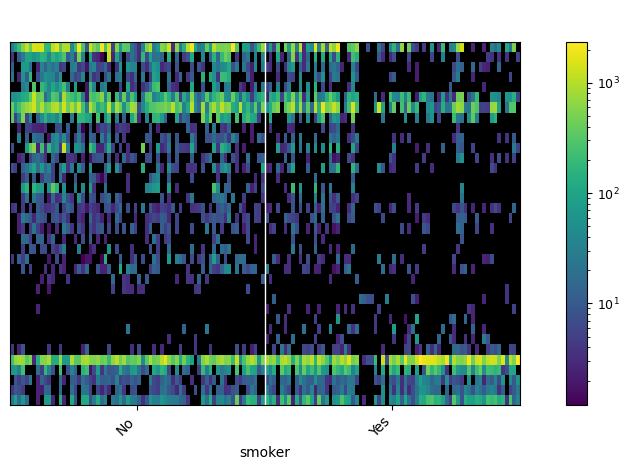

In [23]:
# Diffential abundance
dd_throat = cfs_throat.diff_abundance('smoker','Yes','No', fdr_method='dsfdr', alpha = 0.05, 
                                      random_seed=2018)
dd_throat.plot(sample_field = 'smoker')

Overall, there are 36 samples that have a statistically significant differrence in abundance between the two groups. In these samples, there are 11 samples that have a higher abundance in the Smokers group and 25 samples that have higher abundance in the Non-smokers group.

In [24]:
# Report OTUs
otu_ids = set(dd_throat.feature_metadata.index)

# Loop through each OTU_ID in the set
final_taxonomy_df['OTU_ID'] = final_taxonomy_df['OTU_ID'].astype(str)
otu_ids = {str(otu_id) for otu_id in otu_ids}

for otu_id in otu_ids:
    if otu_id in final_taxonomy_df['OTU_ID'].values:
        
        # Get the corresponding taxonomy row and apply pre-defined function 
        taxonomy_row = final_taxonomy_df.loc[final_taxonomy_df['OTU_ID'] == otu_id]
        informative_taxonomy = get_most_informative_taxonomy(taxonomy_row.iloc[0])
        
        # Display the OTU_ID and its most informative taxonomy
        print(f"OTU_ID: {otu_id} - {informative_taxonomy}")
    else:
        print(f"OTU_ID: {otu_id} not found in the taxonomy data.")

OTU_ID: 259015 -  Veillonellaceae
OTU_ID: 4433523 -  Capnocytophaga
OTU_ID: 4451646 -  Capnocytophaga
OTU_ID: 229136 -  Microbacteriaceae
OTU_ID: 218785 -  Neisseria
OTU_ID: 4477696 -  Haemophilus  parainfluenzae
OTU_ID: 4419379 -  [Prevotella]
OTU_ID: 1042479 -  Prevotella  melaninogenica
OTU_ID: 342427 -  Veillonella  dispar
OTU_ID: 4468073 -  Capnocytophaga
OTU_ID: 3297209 -  Rhodocyclaceae
OTU_ID: 178627 -  Lachnospiraceae
OTU_ID: 347882 -  RF16
OTU_ID: 4443201 -  Tannerella
OTU_ID: 3291558 -  Campylobacter
OTU_ID: 171202 -  Prevotella
OTU_ID: 215266 -  Dialister
OTU_ID: 253550 -  Bacteroidales
OTU_ID: 4374639 -  Haemophilus  parainfluenzae
OTU_ID: 4475758 -  Veillonella  dispar
OTU_ID: 341460 -  Haemophilus
OTU_ID: 1036557 -  Neisseria  subflava
OTU_ID: 557665 -  Prevotella
OTU_ID: 4451251 -  Atopobium
OTU_ID: 3931 -  Treponema
OTU_ID: 621166 -  Veillonellaceae
OTU_ID: 252267 -  Treponema
OTU_ID: 677680 -  [Prevotella]
OTU_ID: 4460604 -  Clostridiales
OTU_ID: 4484389 -  Bergeriell

## 3.3 Are these results the same as those obtained in Task 2? Explain why

In [25]:
print('%d different bacteria between Task 2 and Task 3 Nose' 
      % len(set(dd_2.feature_metadata.index)^set(dd_nose.feature_metadata.index)))

print('%d different bacteria between Task 2 and Task 3 Throat' 
      % len(set(dd_2.feature_metadata.index)^set(dd_throat.feature_metadata.index)))

62 different bacteria between Task 2 and Task 3 Nose
81 different bacteria between Task 2 and Task 3 Throat


The results from Task 3 are not the same as those obtained in Task 2. 

- Task 2 compares the abundance of bacteria between smokers and non-smokers across all sampling sites. This analysis considers all sites together by including samples from both the nose and the throat. Thus, it provides a broad overview of which bacteria differ in abundance between smokers and non-smokers without accounting for the sampling sites, which can mask or dilute site-specific effects.

- Task 3, on the other hand, separates the data by specific sampling sites (nose and throat), allowing for the identification of bacteria that are differentially abundant in a site-specific manner. Smoking can have varying effects on different anatomical sites due to differences in tissue type, airflow, exposure to smoke, and immune responses. The microbiome in each site may adapt or react differently to smoking, leading to distinct bacterial profiles in the nose and throat. These site-specific effects are detectable in Task 3 but might be obscured in the overall analysis when all sites are combined. Therefore, by focusing on site-specific, Task 3 can capture these interaction effects between smoking and sampling site.

The different results between Task 2 and Task 3 highlight the importance of considering sampling sites independently when studying microbial communities. While Task 2 provides a broad overview, Task 3 offers more detailed insights into how smoking affects bacterial abundance in specific sites (nose and throat). The differences in results are expected and provide valuable information about the localised impact of smoking on the microbiome.